In [124]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os

warnings.filterwarnings("ignore")

In [125]:
# 1. Cargar datos
df_2022 = pd.read_csv('2022_limpio.csv', sep=';', parse_dates=['fecha_de_factura'], dayfirst=True)
df_2023 = pd.read_csv('2023_limpio.csv', sep=';', parse_dates=['fecha_de_factura'], dayfirst=True)
df = pd.concat([df_2022, df_2023])

In [126]:
# 2. Limpieza
df['cantidad_neta'] = pd.to_numeric(df['cantidad_neta'], errors='coerce')
#df = df[df['cl_factura'] == 'VENTA']
df = df.dropna(subset=['cantidad_neta'])

In [127]:
# 3. Agrupar ventas diarias por cliente y ciudad
ventas_diarias = df.groupby(['fecha_de_factura', 'solicitante', 'CIUDAD'])['cantidad_neta'].sum().reset_index()
ventas_diarias.columns = ['ds', 'solicitante', 'CIUDAD', 'y']

In [128]:
# 4. Generar lista de combinaciones cliente + ciudad con al menos 180 días
clientes_unicos = ventas_diarias.groupby(['solicitante', 'CIUDAD']).size().reset_index(name='n_dias')
clientes_filtrables = clientes_unicos[clientes_unicos['n_dias'] >= 180]

In [129]:
# 5. Fecha de corte: 18 meses entrenamiento, 6 prueba
fecha_corte = pd.to_datetime("2023-07-01")

In [130]:
# 6. Evaluar cada combinación con Prophet
resultados = []

In [131]:
# 7. Bucle por cada cliente + ciudad
predictions_agg = []

if not os.path.exists('plots'):
    os.makedirs('plots')

for _, row in clientes_filtrables.iterrows():
    cliente = row['solicitante']
    ciudad = row['CIUDAD']

    subset = ventas_diarias[
        (ventas_diarias['solicitante'] == cliente) &
        (ventas_diarias['CIUDAD'] == ciudad)
    ].sort_values('ds')

    train = subset[subset['ds'] < fecha_corte]
    test = subset[subset['ds'] >= fecha_corte]

    # Saltar si no hay suficiente información para prueba
    if len(train) < 100 or len(test) < 30:
        continue

    try:
        # Entrenar modelo
        start_train_time = time.time()
        modelo = Prophet(daily_seasonality=True)
        modelo.fit(train)
        end_train_time = time.time()
        train_time_seconds = end_train_time - start_train_time

        # Generar pronóstico
        start_inference_time = time.time()
        future = modelo.make_future_dataframe(periods=len(test), freq='D')
        forecast = modelo.predict(future)
        end_inference_time = time.time()
        inference_time_seconds = end_inference_time - start_inference_time

        # Comparar con test real
        comparacion = forecast[['ds', 'yhat']].merge(test[['ds', 'y']], on='ds', how='inner')
        if len(comparacion) == 0:
            continue

        # Calcular métricas
        mae = mean_absolute_error(comparacion['y'], comparacion['yhat'])
        promedio_real = comparacion['y'].mean()
        mae_relativo = mae / promedio_real if promedio_real != 0 else None

        accuracy = 1 - mae / promedio_real if promedio_real != 0 else None
        precision = 1 - mae / test['y'].mean() if test['y'].mean() != 0 else None
        recall = 1 - mae / test['y'].mean() if test['y'].mean() != 0 else None
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision is not None and recall is not None) else None

        comparacion_filtrada = comparacion[comparacion['y'] != 0]
        if len(comparacion_filtrada) == 0:
            mape = None
        else:
            mape = (abs((comparacion_filtrada['y'] - comparacion_filtrada['yhat']) / comparacion_filtrada['y'])).mean() * 100

        resultados.append({
            'cliente': cliente,
            'ciudad': ciudad,
            'MAE': mae,
            'Promedio_ventas_test': promedio_real,
            'MAE_relativo': mae_relativo,
            'MAPE (%)': mape,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'observaciones': len(subset),
            'tiempo_entrenamiento_segundos': train_time_seconds,
            'tiempo_inferencia_segundos': inference_time_seconds
        })

        data_plot = pd.DataFrame({
            'fecha': comparacion_filtrada['ds'],
            'real': comparacion_filtrada['y'],
            'pred': comparacion_filtrada['yhat']
        })

        data_plot['ciudad'] = ciudad
        # data_plot['cliente'] = cliente # se omite cliente para no generar tantas gráficas
        predictions_agg.append(data_plot)

        # Graficar Serie temporal: Ventas reales vs. Predicción (se guardan en carpeta plots)
        plt.figure(figsize=(12, 6))
        plt.plot(comparacion_filtrada['ds'], comparacion_filtrada['y'], label='Ventas Reales')
        plt.plot(comparacion_filtrada['ds'], comparacion_filtrada['yhat'], label='Predicción', linestyle='--')
        plt.title(f'Ventas Reales vs. Predicción - Cliente: {cliente} | Ciudad: {ciudad}')
        plt.xlabel('Fecha')
        plt.ylabel('Cantidad Neta')
        plt.legend()
        plt.savefig(f'plots/{ciudad}_cliente_{cliente}_real_vs_pred.png', bbox_inches='tight')
        plt.close()

        # Graficar Scatter plot: Predicción vs. Ventas reales (se guardan en carpeta plots)
        plt.figure(figsize=(8, 6))
        plt.scatter(comparacion_filtrada['y'], comparacion_filtrada['yhat'], alpha=0.6)
        plt.plot([comparacion_filtrada['y'].min(), comparacion_filtrada['y'].max()], [comparacion_filtrada['y'].min(), comparacion_filtrada['y'].max()], 'r--')
        plt.title(f'Scatter: Predicción vs. Ventas reales - Cliente: {cliente} | Ciudad: {ciudad}')
        plt.xlabel('Ventas Reales')
        plt.ylabel('Predicción')
        plt.savefig(f'plots/{ciudad}_cliente_{cliente}_scatter.png', bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Error en {cliente} - {ciudad}: {e}")
        continue

13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:48 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:50 - cmdstanpy - INFO - Chain [1] start processing
13:48:50 - cmdstanpy - INFO - Chain [1] done processing
13:48:51 - cmdstanpy - INFO - Chain [1] start processing
13:48:51 - cmdstanpy - INFO - Chain [1] done processing
13:48:51 - cmdstanpy - INFO - Chain [1] start processing
13:48:51 - cmdstanpy - INFO - Chain [1] done processing
13:48:52 - cmdstanpy - INFO - Chain [1] start processing
13:48:52 - cmdstanpy - INFO - Chain [1] done processing
13:48:52 - cmdstanpy - INFO - Chain [1] start processing
13:48:53 - cmdstanpy - INFO - Chain [1]

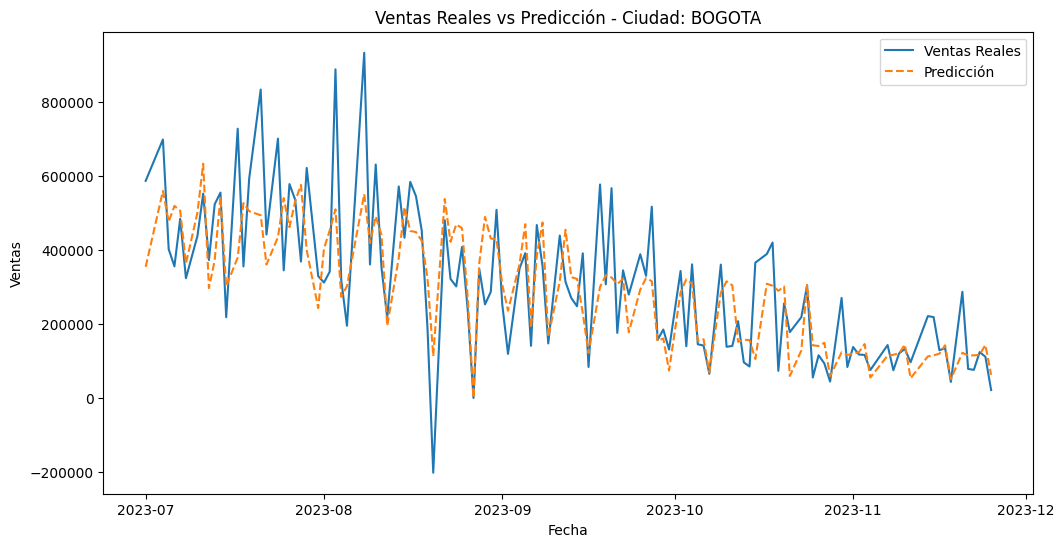

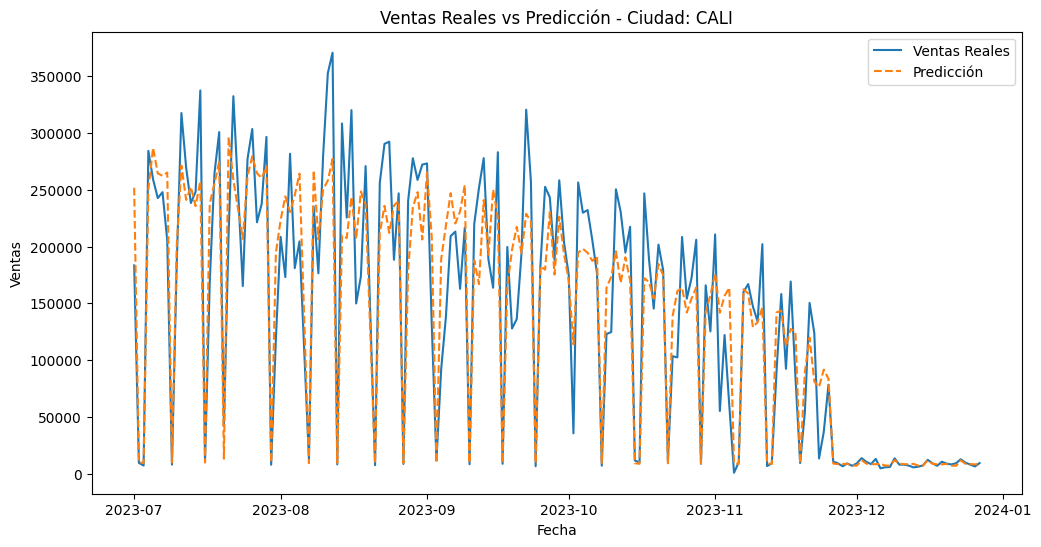

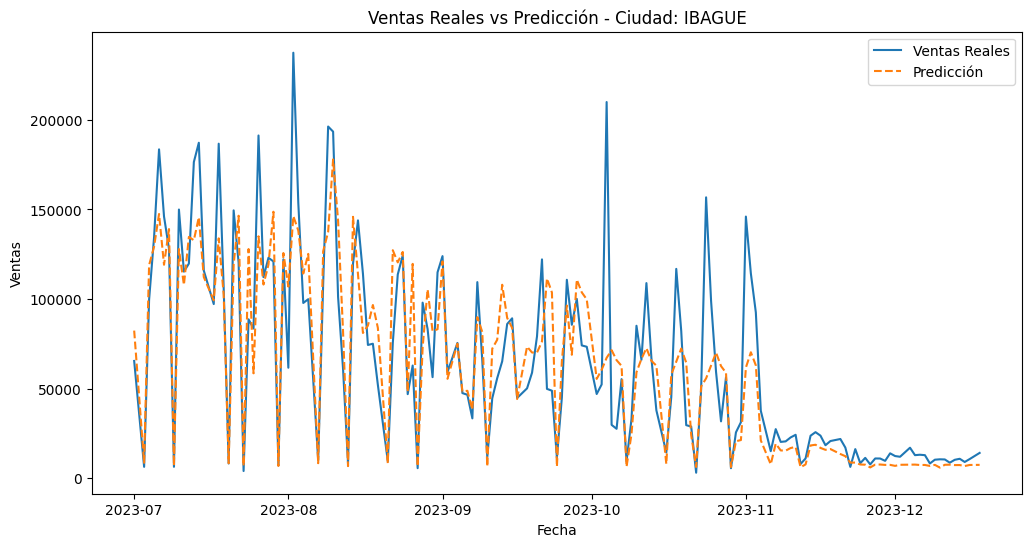

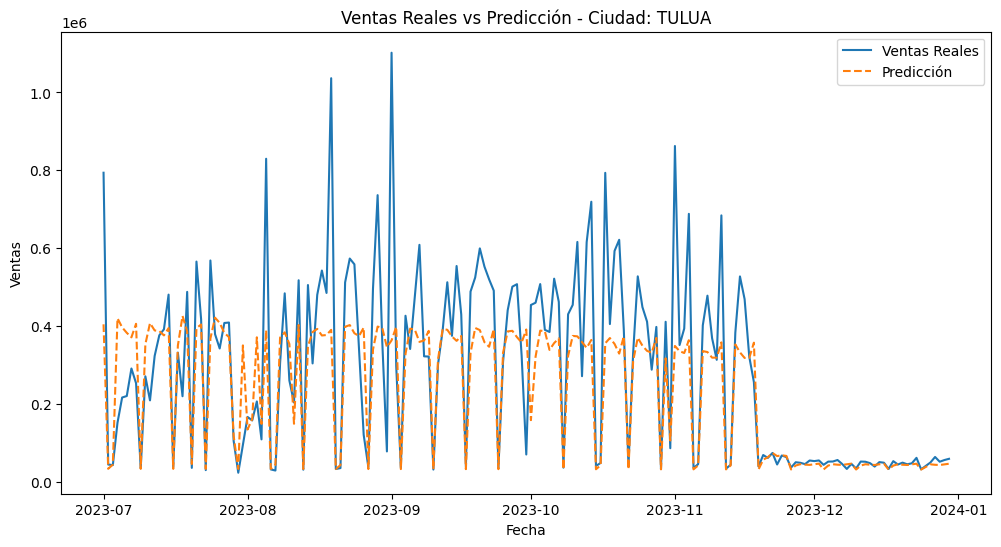

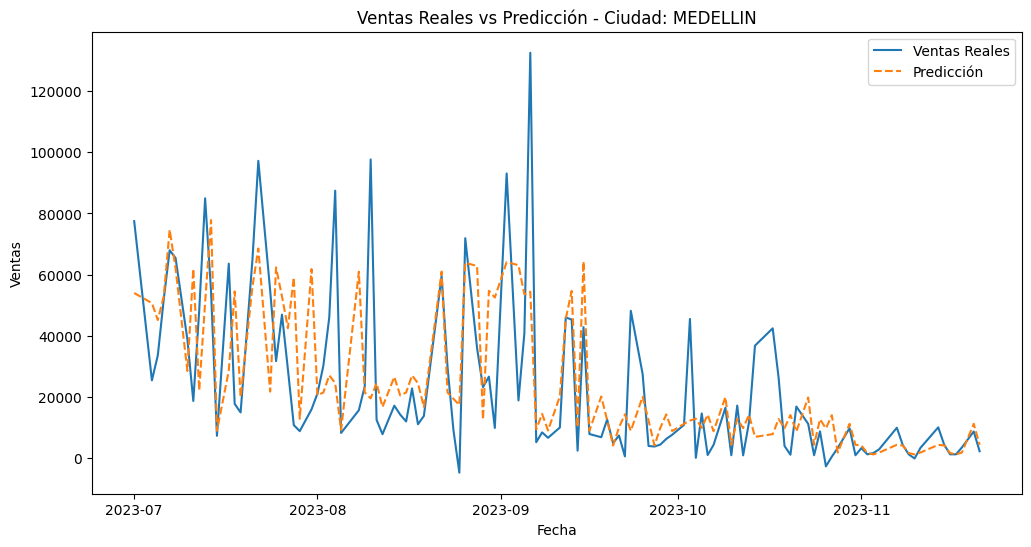

In [132]:
df_predictions = pd.concat(predictions_agg, ignore_index=True)

# 8. Gráfica por cada ciudad
ciudades = df_predictions['ciudad'].unique()
for city in ciudades:
    group = df_predictions[df_predictions['ciudad'] == city].groupby('fecha').agg({'real': 'sum', 'pred': 'sum'}).reset_index()
    plt.figure(figsize=(12,6))
    plt.plot(group['fecha'], group['real'], label='Ventas Reales')
    plt.plot(group['fecha'], group['pred'], label='Predicción', linestyle='--')
    plt.title(f'Ventas Reales vs Predicción - Ciudad: {city}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()

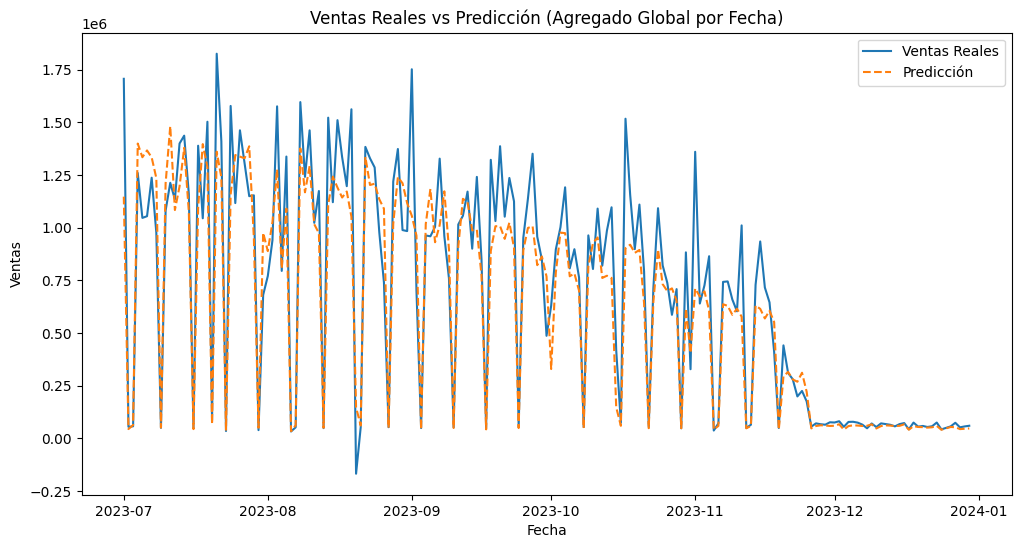

In [133]:
# 9. Grafica Ventas Reales vs Predicción (Agregado Global por Fecha)
df_total = df_predictions.groupby('fecha').agg({'real': 'sum', 'pred': 'sum'}).reset_index()

plt.figure(figsize=(12,6))
plt.plot(df_total['fecha'], df_total['real'], label='Ventas Reales')
plt.plot(df_total['fecha'], df_total['pred'], label='Predicción', linestyle='--')
plt.title('Ventas Reales vs Predicción (Agregado Global por Fecha)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

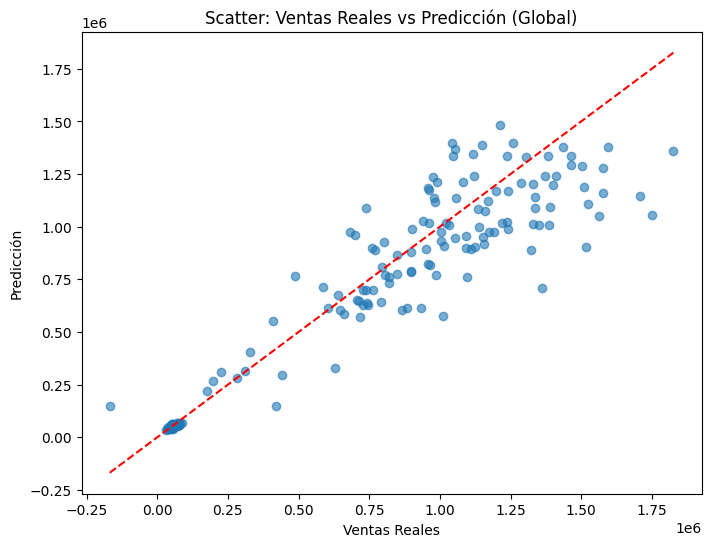

In [134]:
# 11. Grafica Scatter: Ventas Reales vs Predicción (Global)
plt.figure(figsize=(8,6))
plt.scatter(df_total['real'], df_total['pred'], alpha=0.6)
plt.plot([df_total['real'].min(), df_total['real'].max()],
         [df_total['real'].min(), df_total['real'].max()],
         'r--')
plt.title('Scatter: Ventas Reales vs Predicción (Global)')
plt.xlabel('Ventas Reales')
plt.ylabel('Predicción')
plt.show()

In [135]:
# 12. Mostrar resultados
df_resultados = pd.DataFrame(resultados).sort_values('MAE')
df_resultados

,cliente,ciudad,MAE,Promedio_ventas_test,MAE_relativo,MAPE (%),accuracy,precision,recall,f1_score,observaciones,tiempo_entrenamiento_segundos,tiempo_inferencia_segundos
484,1028796.0,IBAGUE,9.076410,115.555556,0.078546,10.187581,0.921454,0.925358,0.925358,0.925358,311,0.125335,0.065465
86,1003113.0,IBAGUE,12.022324,51.428571,0.233767,28.536383,0.766233,0.810627,0.810627,0.810627,192,0.148657,0.055318
227,1016370.0,IBAGUE,13.885713,75.584416,0.183711,16.553256,0.816289,0.815472,0.815472,0.815472,441,0.142255,0.085117
434,1027079.0,BOGOTA,16.643813,57.743363,0.288238,29.532314,0.711762,0.719166,0.719166,0.719166,559,0.146549,0.092258
392,1025888.0,IBAGUE,16.906349,46.000000,0.367529,38.672471,0.632471,0.687600,0.687600,0.687600,246,0.136587,0.043970
...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,1032930.0,BOGOTA,35316.210731,35323.756098,0.999786,8496.907307,0.000214,-0.548299,-0.548299,-0.548299,192,0.187947,0.062973
34,1000936.0,BOGOTA,46778.609780,86951.500000,0.537985,353.640485,0.462015,0.472180,0.472180,0.472180,615,0.181039,0.097406
601,1031842.0,BOGOTA,59035.330618,91012.727273,0.648649,3464.074448,0.351351,0.330012,0.330012,0.330012,204,0.134142,0.046472
242,1018222.0,BOGOTA,91362.498792,144315.680000,0.633074,1669.589181,0.366926,0.315496,0.315496,0.315496,551,0.158500,0.089518


In [136]:
# 13. Clasificación por MAPE
def clasificar_mape(mape):
    if pd.isna(mape):
        return 'Sin datos'
    elif mape < 10:
        return 'Excelente'
    elif mape < 20:
        return 'Buena'
    elif mape < 50:
        return 'Aceptable'
    else:
        return 'Mala'

df_resultados['desempeño'] = df_resultados['MAPE (%)'].apply(clasificar_mape)

In [137]:
print("\nDistribución del desempeño (porcentaje):")
print(df_resultados['desempeño'].value_counts(normalize=True) * 100)
print(df_resultados['MAPE (%)'].mean())


Distribución del desempeño (porcentaje):
desempeño
Mala         50.154321
Aceptable    43.364198
Buena         5.709877
Excelente     0.771605
Name: proportion, dtype: float64
221.8541681106798


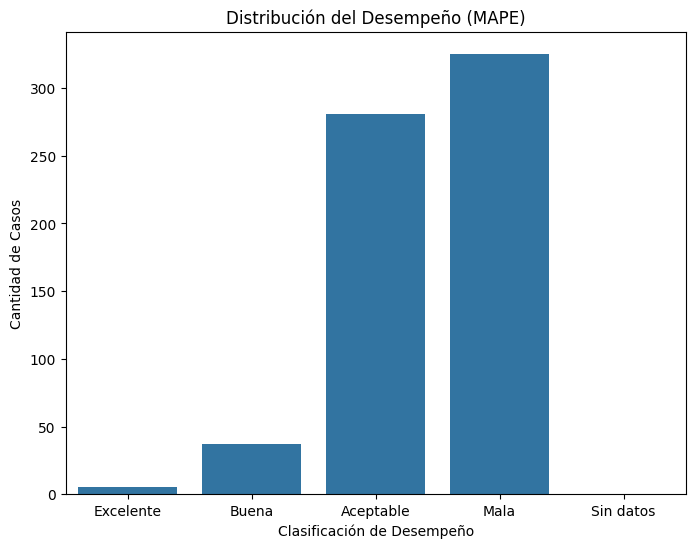

In [138]:
# 14. Distribución del desempeño (por MAPE)
plt.figure(figsize=(8, 6))
sns.countplot(x='desempeño', data=df_resultados, order=['Excelente', 'Buena', 'Aceptable', 'Mala', 'Sin datos'])
plt.title('Distribución del Desempeño (MAPE)')
plt.xlabel('Clasificación de Desempeño')
plt.ylabel('Cantidad de Casos')
plt.show()

In [139]:
# 15. Clasificación por accuracy
def clasificar_accuracy(accuracy):
    if pd.isna(accuracy):
        return 'Sin datos'
    elif accuracy > 0.9:
        return 'Excelente'
    elif accuracy > 0.75:
        return 'Buena'
    elif accuracy > 0.6:
        return 'Aceptable'
    else:
        return 'Mala'

df_resultados['desempeño_accuracy'] = df_resultados['accuracy'].apply(clasificar_accuracy)

In [140]:
print("\nDistribución del desempeño de accuracy (porcentaje):")
print(df_resultados['desempeño_accuracy'].value_counts(normalize=True) * 100)
print(df_resultados['accuracy'].mean())


Distribución del desempeño de accuracy (porcentaje):
desempeño_accuracy
Mala         50.462963
Aceptable    35.802469
Buena        12.962963
Excelente     0.771605
Name: proportion, dtype: float64
0.4565436796250229


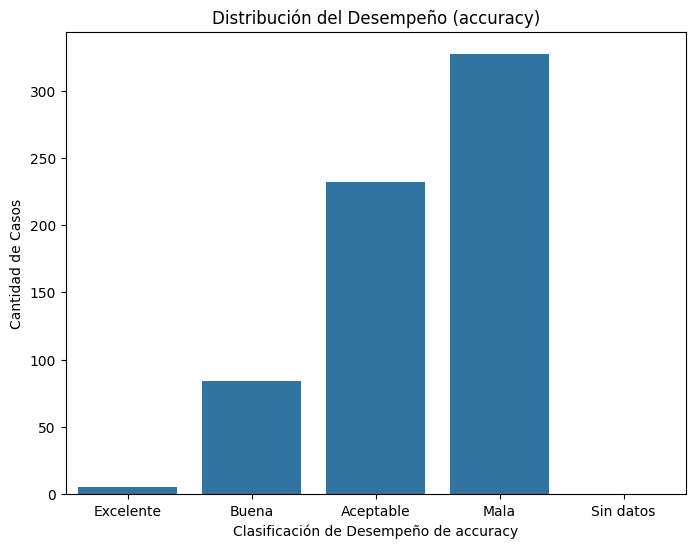

In [141]:
# 16. Distribución del desempeño (por accuracy)
plt.figure(figsize=(8, 6))
sns.countplot(x='desempeño_accuracy', data=df_resultados, order=['Excelente', 'Buena', 'Aceptable', 'Mala', 'Sin datos'])
plt.title('Distribución del Desempeño (accuracy)')
plt.xlabel('Clasificación de Desempeño de accuracy')
plt.ylabel('Cantidad de Casos')
plt.show()


--- Resumen de Tiempos de Complejidad ---

**Tiempos de Entrenamiento (en segundos) para 648 modelos:**
  Tiempo Total: 96.92 segundos (1.62 minutos)
  Promedio por modelo: 0.1496 segundos
  Mediana por modelo: 0.1444 segundos
  Máximo por modelo: 0.7532 segundos
  Mínimo por modelo: 0.1199 segundos

**Tiempos de Inferencia (en segundos) para 648 modelos:**
  Tiempo Total: 41.31 segundos (0.69 minutos)
  Promedio por modelo: 0.0637 segundos
  Mediana por modelo: 0.0564 segundos
  Máximo por modelo: 1.0370 segundos
  Mínimo por modelo: 0.0347 segundos


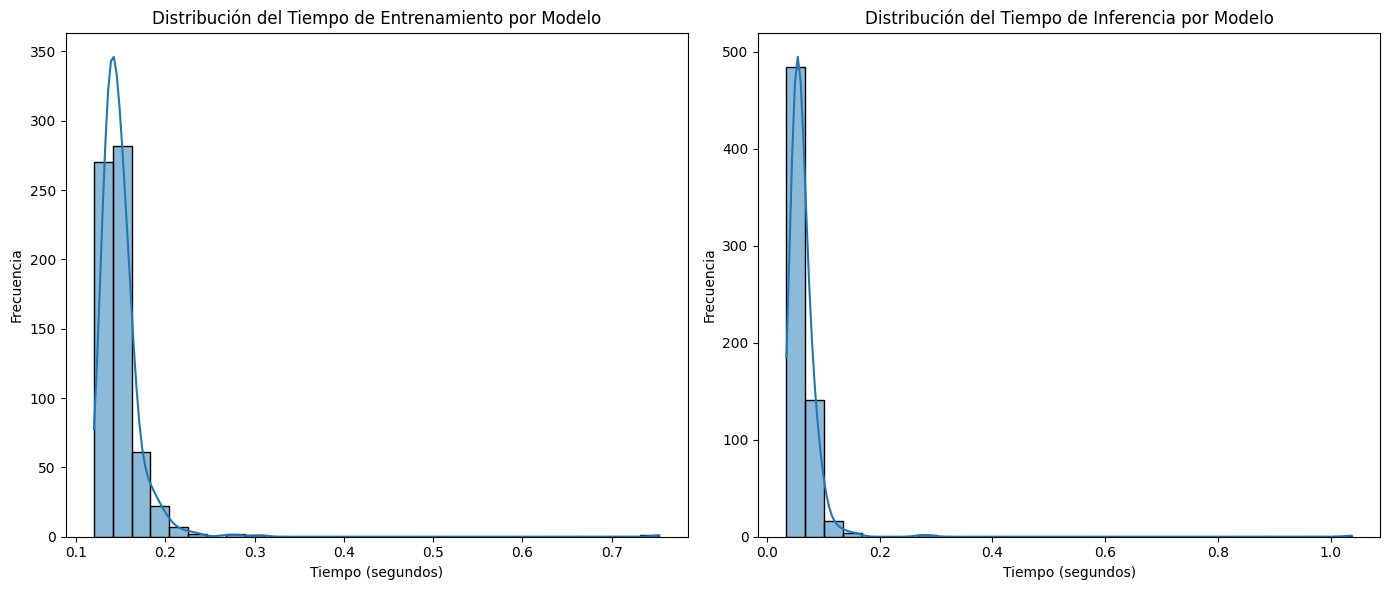

In [142]:
# Análisis de Complejidad (Tiempos de Entrenamiento e Inferencia)

print("\n--- Resumen de Tiempos de Complejidad ---")

# Filtrar solo casos donde se pudo calcular el tiempo (evitar errores None o NaN)
df_tiempos = df_resultados.dropna(subset=['tiempo_entrenamiento_segundos', 'tiempo_inferencia_segundos'])

if not df_tiempos.empty:
    # Estadísticas para el tiempo de entrenamiento
    total_train_time = df_tiempos['tiempo_entrenamiento_segundos'].sum()
    avg_train_time = df_tiempos['tiempo_entrenamiento_segundos'].mean()
    median_train_time = df_tiempos['tiempo_entrenamiento_segundos'].median()
    max_train_time = df_tiempos['tiempo_entrenamiento_segundos'].max()
    min_train_time = df_tiempos['tiempo_entrenamiento_segundos'].min()

    print(f"\n**Tiempos de Entrenamiento (en segundos) para {len(df_tiempos)} modelos:**")
    print(f"  Tiempo Total: {total_train_time:.2f} segundos ({total_train_time / 60:.2f} minutos)")
    print(f"  Promedio por modelo: {avg_train_time:.4f} segundos")
    print(f"  Mediana por modelo: {median_train_time:.4f} segundos")
    print(f"  Máximo por modelo: {max_train_time:.4f} segundos")
    print(f"  Mínimo por modelo: {min_train_time:.4f} segundos")

    # Estadísticas para el tiempo de inferencia
    total_inference_time = df_tiempos['tiempo_inferencia_segundos'].sum()
    avg_inference_time = df_tiempos['tiempo_inferencia_segundos'].mean()
    median_inference_time = df_tiempos['tiempo_inferencia_segundos'].median()
    max_inference_time = df_tiempos['tiempo_inferencia_segundos'].max()
    min_inference_time = df_tiempos['tiempo_inferencia_segundos'].min()

    print(f"\n**Tiempos de Inferencia (en segundos) para {len(df_tiempos)} modelos:**")
    print(f"  Tiempo Total: {total_inference_time:.2f} segundos ({total_inference_time / 60:.2f} minutos)")
    print(f"  Promedio por modelo: {avg_inference_time:.4f} segundos")
    print(f"  Mediana por modelo: {median_inference_time:.4f} segundos")
    print(f"  Máximo por modelo: {max_inference_time:.4f} segundos")
    print(f"  Mínimo por modelo: {min_inference_time:.4f} segundos")

    # Visualización de la distribución de tiempos
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_tiempos['tiempo_entrenamiento_segundos'], bins=30, kde=True)
    plt.title('Distribución del Tiempo de Entrenamiento por Modelo')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Frecuencia')

    plt.subplot(1, 2, 2)
    sns.histplot(df_tiempos['tiempo_inferencia_segundos'], bins=30, kde=True)
    plt.title('Distribución del Tiempo de Inferencia por Modelo')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

else:
    print("No hay datos de tiempo disponibles para analizar.")

In [143]:
# Guardar resultados en Excel
df_resultados.to_excel('resultados_modelo_prophet.xlsx', index=False)